# CITS4403 Slime Mould Project
## Wenxiao Zhang - 22792191

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from slime.city import City
import pandas as pd
import networkx as nx
import math
import utils

## Load and preprocess the dataset 

In [2]:
stations = gpd.read_file('database/nanjing_nodes.geojson')
routes = gpd.read_file('database/nanjing_edges.geojson')
# drop irrelevant columns and null value
stations = stations.drop(['name', 'marker-symbol', 'marker-size'], axis=1)
routes = routes.drop(['name', 'ref'], axis=1).reset_index()
stations = stations[~stations['marker-color'].isnull()].reset_index().drop(['index', 'marker-color'], axis=1)

### Preprocess nodes

In [3]:
stations['lon'], stations['lat'] = stations.geometry.x, stations.geometry.y
stations['value'] = 4
min_lon = min(stations['lon'])
min_lat = min(stations['lat'])
# scaling lon lat values
stations['x'] = stations.lon.apply(lambda x: int((x - min_lon) * (10**3)))
stations['y'] = stations.lat.apply(lambda y: int((y - min_lat) * (10**3)))
# subset the data
stations = stations[((stations['x']>150) & (stations['x']<500)) & ((stations['y']>530) & (stations['y']<800))]
min_x = min(stations['x'])
min_y = min(stations['y'])
stations['x'] = stations.x.apply(lambda x: int(x - min_x)+10)
stations['y'] = stations.y.apply(lambda y: int(y - min_y)+10)
stations['nodes'] = stations[['x', 'y']].apply(tuple, axis=1)
stations.head()

,geometry,lon,lat,value,x,y,nodes
0,POINT (118.86386 32.04167),118.863858,32.041670,4,201,163,"(201, 163)"
1,POINT (118.77903 32.05296),118.779027,32.052965,4,116,174,"(116, 174)"
2,POINT (118.98216 32.08657),118.982163,32.086573,4,320,208,"(320, 208)"
4,POINT (118.78943 32.04412),118.789430,32.044122,4,127,166,"(127, 166)"
5,POINT (118.71428 31.96781),118.714278,31.967809,4,52,89,"(52, 89)"


### Preprocess edges

In [4]:
routes['nodes'] = "None"
for i, route in routes.iterrows():
    nodes = [None] * len(route['geometry'].coords)
    for point in stations['geometry']:
        if route['geometry'].distance(point) < 1e-3:
            min_dist = -1
            min_j = 0
            for j, node in enumerate(route['geometry'].coords):
                idx = (point.x, point.y)
                dist = math.dist(node, idx) 
                if dist < min_dist or min_dist == -1:
                    min_dist = dist
                    min_j = j
            nodes[min_j] = idx
    nodes = [x for x in nodes if x]
    routes.at[i, 'nodes'] = nodes

In [5]:
routes = routes[routes['nodes'].map(lambda d: len(d)) > 0]
routes.head()

,index,stroke,geometry,nodes
4,4,#da60cd,"LINESTRING (118.50250 31.90719, 118.50285 31.9...","[(118.6722186, 31.9552622), (118.683263, 31.97..."
5,5,#da60cd,"LINESTRING (118.79535 31.97445, 118.79168 31.9...","[(118.79161425000001, 31.972915), (118.7737849..."
6,6,#009651,"LINESTRING (118.66625 32.16569, 118.66741 32.1...","[(118.74106885, 32.141935000000004), (118.7646..."
7,7,#009651,"LINESTRING (118.82616 31.87100, 118.82617 31.8...","[(118.82522854999999, 31.89797195), (118.82479..."
8,8,#eac384,"LINESTRING (118.61153 32.04795, 118.61221 32.0...","[(118.69870315, 32.03429885), (118.71026495000..."


## Visualise the data in Networkx

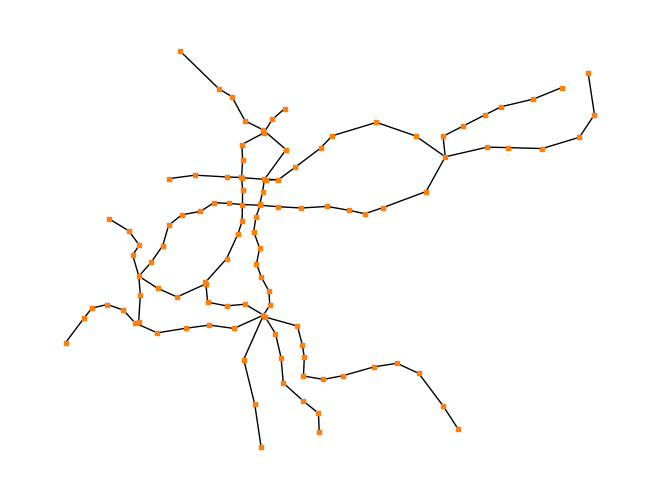

In [6]:
G = nx.Graph()
for nodes in routes['nodes']:
    for seg_start, seg_end in zip(nodes, nodes[1:]):
        G.add_edge(seg_start, seg_end)
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

nx.draw(G, positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)

## Slime Mould

In [7]:
start_loc = (stations.at[20,'x'], stations.at[20,'y'])

### Initialise experiment area

In [8]:
city = City(city_shape=(max(stations.x) + 50, max(stations.y) + 50), foods=stations, start_loc=start_loc, mould_shape=(5, 5), init_mould_coverage=1, decay=0.2)

### Execute 100 steps

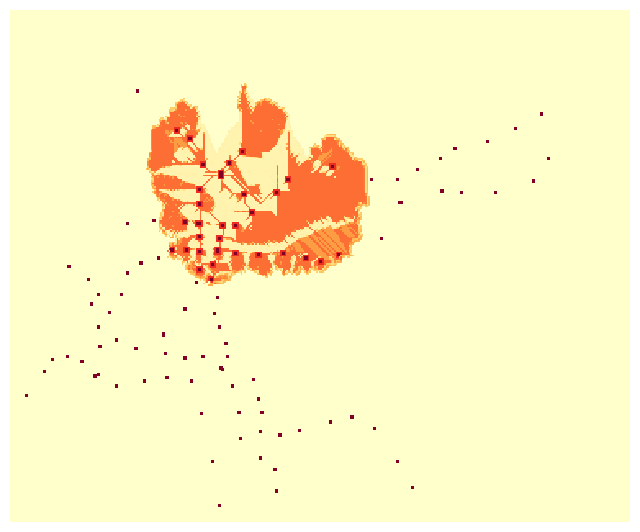

In [9]:
city.animate(frames=100, interval=100, filename="output/test2.gif")
plt.show()

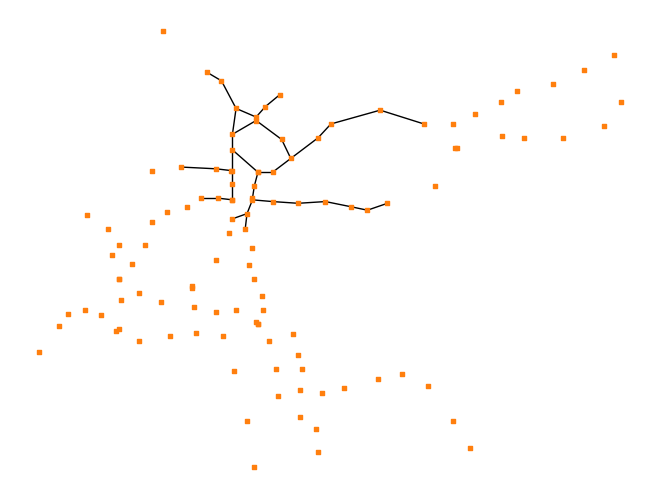

In [10]:
nx.draw(city.food_graph, city.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)

### Execute 250 more steps

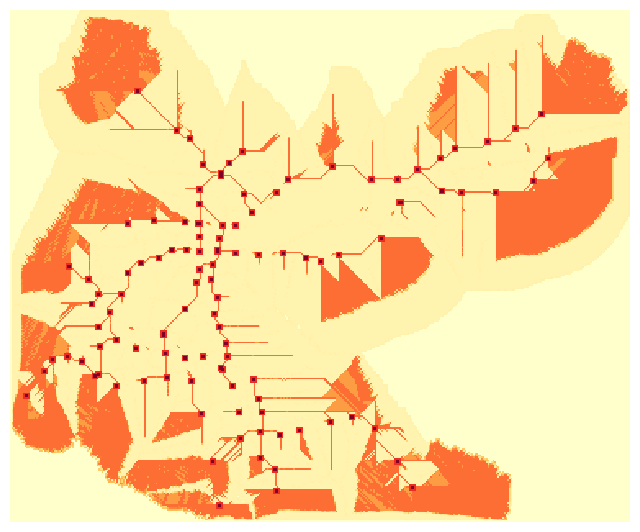

In [11]:
city.animate(frames=250, interval=100, filename="output/test3.gif")
plt.show()

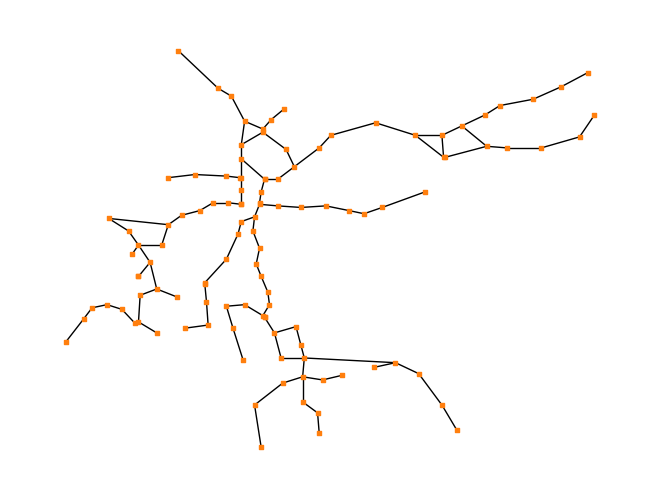

In [12]:
nx.draw(city.food_graph, city.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)

## Graph Analysis

### Clustering coefficient

In [13]:
print('Original graph: '+str(utils.clustering_coefficient(G)))
print('Graph connected by slime mould: '+str(utils.clustering_coefficient(city.food_graph)))

Original graph: 0.01419141914191419
Graph connected by slime mould: 0.02604166666666666


### Path length

In [14]:
print('Original graph: '+str(utils.characteristic_path_length(G)))
print('Graph connected by slime mould: '+str(utils.characteristic_path_length(city.food_graph)))

Original graph: 12.491795366795367
Graph connected by slime mould: 15.410494752623688


## Agent Analysis

### Average phermone

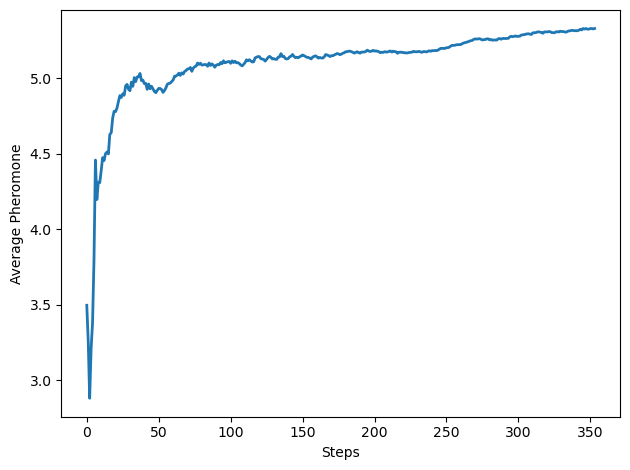

In [16]:
plt.plot(city.mould.get_avg_ph())
utils.decorate(xlabel='Steps', ylabel='Average Pheromone', loc='upper left')

### Total number of Agent

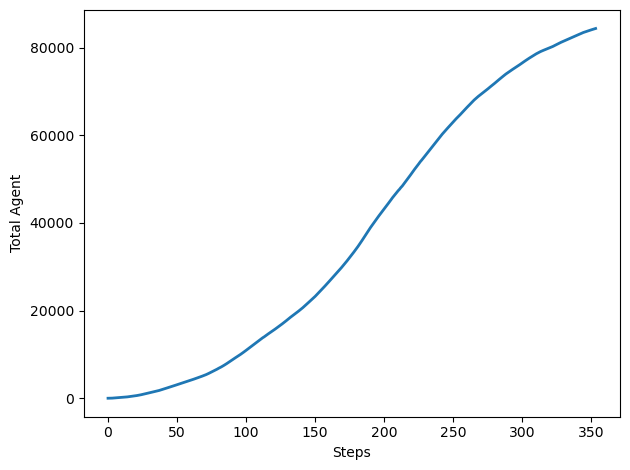

In [18]:
plt.plot(city.mould.get_total_num())
utils.decorate(xlabel='Steps', ylabel='Total Agent', loc='upper left')